# M1.P2. Benchmarking

## I. Why Benchmark?
In this course we will understand about HPC, parallelism, concurrency, and distributed computing. By the end of the course you should be able to  modify serial code to make it parallel or concurrent, where appropriate, and you should have some concepts on writing parallel algorithms and workflows yourself. In order to do this well, you need to be able to benchmark your algorithms and the systems they run on. You know the basics of how to analyze parallel algorithms, but it's always useful to collect empirical measurements, and it's also usually easier to collect empirical data than it is to do mathematical analysis of parallel algorithms.

So, now that we're through with that, what is benchmarking? A _benchmark_ is the act of running a computer program, a set of programs, or other operations, in order to assess the relative performance of an object, normally by running a number of standard tests and trials against it. Benchmarking is usually associated with assessing performance characteristics of computer hardware, for example, the floating point operation performance of a CPU, but there are circumstances when the technique is also applicable to software. In this notebook, we will be doing a bit of both. The following graph is an example of historical benchmarks going back to 1996:
![benchmarks of old](http://preshing.com/images/float-point-perf.png)

### Example 2.1 - Reading Files Vs Reading From Memory
When possible, you should try and stay away from reading and writing to disk as much as possible? It is much slower to read and write to disk than it is to memory. In this example, we're going to quantify that. I've designed a [python decorator](https://www.python.org/dev/peps/pep-0318/) to be used as a timer. In order to use it, you "decorate" a function with it by putting `@timed` over the function definition. You'll see what I mean by this in the code cell below. In this example, we're going to create a multidimensional array, store it to memory, and read it from memory. Then, we're going to do the same with a file. We'll use the decorator to time it.

In [9]:
import time

def timed(func):
    """
      decorator to calculate the total
      time of a function
    """

    def st_func(*args, **keyArgs):
        t1 = time.time()
        r = func(*args, **keyArgs)
        t2 = time.time()
        print( "Function=%s, Time=%ssec" % (func.__name__, t2 - t1))
        return r

    return st_func

@timed
def memory_test():
    import random
    arr = [[[x for x in range(100)] for y in range(100)] for z in range(10)]
    print(len(arr))
    
@timed
def file_test():
    import ast
    # Note that the array is much smaller in the file test
    # But it is still **MUCH** slower
    arr = [[[x for x in range(100)] for y in range(100)] for z in range(10)]
    with open("data/matrix.out", "w") as f:
        f.write(str(arr))
    with open("data/matrix.out") as f:
        arr = ast.literal_eval(f.read())
    print(len(arr))

In [10]:
memory_test()
file_test()

100
Function=memory_test, Time=0.054340362548828125sec
100
Function=file_test, Time=7.584920406341553sec


## II. Single Machine Benchmarking
What we did in the last example was a benchmark of a single core algorithm, in order to learn for sure that file IO is much slower than reading and writing to memory. Now, we want to test a parallel algorithm and see how fast we can get it to go, on a single machine. 

### Example 2.2 - Timing Parallel Algorithms on One Machine
To time parallel algorithms, we're going to use our monte carlo frog simulation from before. We'll time it and graph the times for different numbers of cores. Recall that there were three for loops nested within each other and we parallelized the outer loop. As an exercise, feel free to parallelize the middle and inner loops.

In [16]:
%%time
# Parallel frog solution

import math
import random
import time
from multiprocessing import Pool


# We parallelize the same way here, by turning for loops into functions and mapping to them

def outer_loop(numJumps):
    numTries=1000
    lenJump=1
    numSuccesses=0
    #randomly test 1 million times and see what happens
    for j in range(numTries):
        #vector representing distance of 0 from origin
        frogPosition=[0.0,0.0]
        for i in range(0,numJumps,1):
            #generate a random angle
            theta=random.uniform(0,2*math.pi)
            #add to x and y components of frog position vectors
            frogPosition[0]+=lenJump*math.cos(theta)
            frogPosition[1]+=lenJump*math.sin(theta)
        #compute magnitude of final frog position vector
        frogMagnitude=((frogPosition[0]**2+frogPosition[1]**2)**0.5)

        #check if frog landed where we wanted it to
        if frogMagnitude<=1.0:
            #keep track of successes
            numSuccesses+=float(1)
    
    #compute success rate
    successRate=float(numSuccesses/numTries)    
    # print("If the frog jumps %s times, it will land in the original circle\
    # approximately %s times, representing a success rate of %s"%(numJumps,int(numSuccesses),successRate))

times = []
for i in range(1,32, 2):
    # Note that this takes a while to run - about a minute
    pool = Pool(i)
    before = time.time()
    tasks = [pool.apply_async(outer_loop, (j,)) for j in range(1,20)]
    tasks[-1].get()
    after = time.time()
    tot = after - before
    times.append(tot)
    print("{} Cores, {} Sec".format(i, tot))

1 Cores, 0.18744850158691406 Sec
3 Cores, 0.08284950256347656 Sec
5 Cores, 0.06947946548461914 Sec
7 Cores, 0.07489895820617676 Sec
9 Cores, 0.08874177932739258 Sec
11 Cores, 0.07049393653869629 Sec
13 Cores, 0.07024192810058594 Sec
15 Cores, 0.0685122013092041 Sec
17 Cores, 0.07156252861022949 Sec
19 Cores, 0.07312273979187012 Sec
21 Cores, 0.06778073310852051 Sec
23 Cores, 0.06474876403808594 Sec
25 Cores, 0.07517170906066895 Sec
27 Cores, 0.06686282157897949 Sec
29 Cores, 0.06573128700256348 Sec
31 Cores, 0.14231276512145996 Sec
CPU times: user 871 ms, sys: 1.95 s, total: 2.82 s
Wall time: 4.29 s


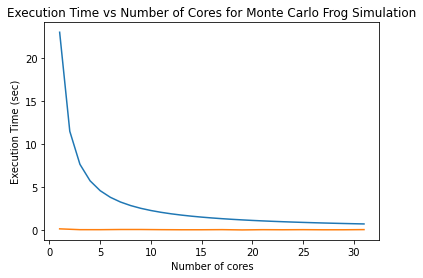

In [13]:
%matplotlib inline
# Plot the times we collected
import matplotlib.pyplot as plt
import numpy as np

#h Helper function to plot an equation
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x) 
    plt.plot(x, y)  

# Graph theoretical maximum (in blue)
graph(lambda x: 23/x, range(1, 32))

# Graph empirical data (in orange)
plt.plot(range(1,32, 2), times)

plt.ylabel("Execution Time (sec)")
plt.xlabel("Number of cores")
plt.title("Execution Time vs Number of Cores for Monte Carlo Frog Simulation")
plt.show()

## III. Distributed Benchmarking
Distributed benchmarking is, as it sounds, benchmarking a distributed algorithm on a distributed system. Many of the considerations you need to make when you write a distributed algorithm also need to be made when you benchmark a distributed algorithm as well. You need to worry about what parts of your algorithm can run concurrently, as often, things can be offloaded to remote machines if they can be run concurrently. You need to worry about which parts of your process need to access things from other parts, because you can't depend on all of the remote parts of your code having access to the same memory pool as any other part. Because of this, you need to worry about how you can have the processes communicate with each other. Because of all of this complexity, you need to make sure you know how you can ensure that your benchmarking does not affect the output or speed of your algorithm.

## System Benchmarking
So we've done a bunch of benchmarking of our software. Next, we are going to do some hardware benchmarking. Earlier in the notebook, I said "Benchmarking is usually associated with assessing performance characteristics of computer hardware, for example, the floating point operation performance of a CPU", and we're about to calculate exactly that. 

The way we will do this is by the following process: First, come up with a task that will take a constant amount of computer power. Then, compute what that amount of power is, by counting the number of floating point instructions that it will take to run the code. Then, repeatedly time the code and divide the number of floating point instructions by the time it took to get a measurement in FLOPS of how performant our computer is.

### Example 2.4 - Using a Workflow to Estimate System Power
We're going to perform a fixed number of floating point instructions, specifically floating point adds, in a Python loop. Note that there is significant overhead involved with starting a python loop, so the quote of roughly 20 MFLOPS (last time I tested it) is quite a low estimate for this single machine.

In [18]:
import time

before = time.time()
for i in range(10 ** 6):
    floating_point = 1.0
    float_increment = 1.0
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
    floating_point += float_increment
after = time.time()
tot = after-before
print("20M FLOP in {} sec, {}GFLOPS".format(tot, ((20.5**7)/tot)/10**6))

20M FLOP in 1.1304957866668701 sec, 1345.8853917371273GFLOPS


##  End of practice
